# GABAsyn testing

This is a test suite for GABA-ergic synapses on the Gillies-Willshaw STN neuron model, using GABAsyn.mod

In [1]:
%matplotlib notebook
# Enable connecting with ipyton console --existing
%connect_info

{
  "stdin_port": 50721, 
  "ip": "127.0.0.1", 
  "control_port": 50722, 
  "hb_port": 50723, 
  "signature_scheme": "hmac-sha256", 
  "key": "903e794a-56dd-4bff-b583-a06fb21eb160", 
  "kernel_name": "", 
  "shell_port": 50719, 
  "transport": "tcp", 
  "iopub_port": 50720
}

Paste the above JSON into a file, and connect with:
    $> ipython <app> --existing <file>
or, if you are local, you can connect with just:
    $> ipython <app> --existing C:\Users\lkoelman\AppData\Roaming\jupyter\runtime\kernel-22a52051-e712-42fa-b04f-34cf98a27a3c.json 
or even just:
    $> ipython <app> --existing 
if this is the most recent IPython session you have started.


In [2]:
# NEURON modules
import neuron
from neuron import h
h.load_file("stdlib.hoc") # Load the standard library
h.load_file("stdrun.hoc") # Load the standard run library

# Add our own modules to Python path
import sys, os.path
scriptdir = os.path.abspath('.')
modulesbase = os.path.normpath(os.path.join(scriptdir, '..'))
sys.path.append(modulesbase)

# Gillies-Willshaw STN model
import gillies_model as gillies

# Plotting & recording
from common import analysis

# Physiological parameters
import cellpopdata as cpd
from cellpopdata import PhysioState, Populations as Pop, NTReceptors as NTR, ParameterSource as Cit

# STN cell testing
from stn_model_evaluation import *

Mechanisms already loaded from path: nrn_mechs.  Aborting.


## Configure synapse

First we define a function to set up the inputs. This is an extension function to `stn_model_evaluation.py/STNModelEvaluator`

In [3]:
def make_GABA_inputs(self):
    """
    Make a single GABAergic synapse on the STN neuron.
    """
    cc = cpd.CellConnector(self.physio_state, self.rng)

    # Allocate data for input
    self.model_data[self.target_model]['inputs'] = {}
        
    # Add GPe inputs using Tsodyks-Markram synapses
    n_gpe_syn = 1 # NOTE: one synapse represents a multi-synaptic contact from one GPe axon
    gpe_syns = []
    gpe_ncs = []
    gpe_stims = []
    gpe_handlers = []

    # Pick random segments in dendrites for placing synapses
    is_gpe_target = lambda seg: seg.diam > 1.0 # select proximal dendrites
    dendrites = self.model_data[self.target_model]['sec_refs']['dendrites']
    dend_secrefs = sum(dendrites, [])
    gpe_target_segs = pick_random_segments(dend_secrefs, n_gpe_syn, is_gpe_target, rng=self.rng)

    # Make synapses
    gpe_wvecs = []
    for target_seg in gpe_target_segs:

        # Make poisson spike generator
        stim_rate = 33.0 # hz
        stim_T = stim_rate**-1*1e3
        stimsource = h.NetStim() # Create a NetStim
        stimsource.interval = stim_T # Interval between spikes
        stimsource.number = 1e9 # max number of spikes
        stimsource.noise = 0.0 # Fractional noise in timing
        gpe_stims.append(stimsource) # Save this NetStim

        # Custom synapse parameters
        syn_mech = 'GABAsyn'
        syn_params = {
            'use_stdp_A': 1,
            'use_stdp_B': 1,
        }

        # Make synapse and NetCon
        syn, nc, wvecs = cc.make_synapse((Pop.GPE, Pop.STN), (stimsource, target_seg), 
                            syn_mech, (NTR.GABAA, NTR.GABAB), 
                            (Cit.Custom, Cit.Chu2015, Cit.Fan2012, Cit.Atherton2013),
                            custom_synpar=syn_params)

        print("Made {} synapse with following parameters:".format(syn_mech))
        for pname in cc.getSynMechParamNames(syn_mech):
            print("{} : {}\n".format(pname, str(getattr(syn, pname))))

        # Compensate for effect max value Hill factor and U1 on gmax_GABAA and gmax_GABAB
        syn.gmax_GABAA = syn.gmax_GABAA / syn.U1
        syn.gmax_GABAB = syn.gmax_GABAB / 0.21

        # Control netstim
        tstart, tstop = 100, 100 + 10*stim_T
        stimsource.start = tstart
        turn_off = h.NetCon(None, stimsource)
        turn_off.weight[0] = -1
        def queue_events():
            turn_off.event(tstop)
        fih = h.FInitializeHandler(queue_events)

        gpe_handlers.append(fih)
        gpe_handlers.append(turn_off)
        gpe_ncs.append(nc)
        gpe_syns.append(syn)
        gpe_wvecs.extend(wvecs)

    # Save inputs
    self.model_data[self.target_model]['inputs']['gpe'] = {
        'stimweightvec': gpe_wvecs,
        'synapses': gpe_syns,
        'NetCons': gpe_ncs,
        'NetStims': gpe_stims,
        'InitHandlers': gpe_handlers,
    }

## Configure recording

Record variables of interest

In [ ]:
def rec_traces(self, recordStep=0.025):
    """
    Set up recording Vectors
    """
    somasec = h.SThcell[0].soma
    dendsec = h.SThcell[0].dend1[7]

    # Assign label to each recorded section
    rec_segs = {
        'soma': somasec(0.5), # middle of soma
        'dist_dend': dendsec(0.8), # approximate location along dendrite in fig. 5C
    }

    self.model_data[self.target_model]['rec_segs'] = rec_segs
    
    # END COMMON PART ##############################################################
    
    # Start trace specification
    traceSpecs = collections.OrderedDict() # for ordered plotting (Order from large to small)
    traceSpecs['t_global'] = {'var':'t'}
    self.rec_dt = recordStep
    
    # Add synapse and segment containing it
    nc = self.model_data[self.target_model]['inputs']['gpe']['NetCons'][0]
    rec_segs['synGABA'] = nc.syn()
    rec_segs['postseg'] = nc.syn().get_segment()

    # Record synaptic variables
    traceSpecs['gA_syn'] = {'pointp':'synGABA', 'var':'g_GABAA'}
    traceSpecs['gB_syn'] = {'pointp':'synGABA', 'var':'g_GABAB'}
    traceSpecs['Rrp_syn'] = {'pointp':'synGABA', 'var':'Rrp'}
    traceSpecs['Use_syn'] = {'pointp':'synGABA', 'var':'Use'}
    traceSpecs['Hill_syn'] = {'pointp':'synGABA', 'var':'G'}

    # Record membrane voltages
    for seclabel, seg in rec_segs.iteritems():
        if isinstance(seg, neuron.nrn.Segment):
            traceSpecs['V_'+seclabel] = {'sec':seclabel, 'loc':seg.x, 'var':'v'}
            
    # Prepare dictionary (label -> Section)
    rec_secs = {}
    for seclabel, hobj in rec_segs.iteritems():
        if isinstance(hobj, neuron.nrn.Segment):
            rec_secs[seclabel] = hobj.sec
        else:
            rec_secs[seclabel] = hobj # point process

    # Use trace specs to make Hoc Vectors
    recData = analysis.recordTraces(rec_secs, traceSpecs, recordStep)

    # Save trace specs and recording Vectors
    self.model_data[self.target_model]['rec_data'][protocol] = {
        'trace_specs': traceSpecs,
        'trace_data': recData,
        'rec_dt': recordStep,
    }

## Configure ploting
Plot variables of interest

In [4]:
def plot_traces(self):
    """
    Plot traces for our simulation
    """
    # Get data
    model = self.target_model
    traceSpecs = self.model_data[model]['rec_data'][protocol]['trace_specs']
    recData = self.model_data[model]['rec_data'][protocol]['trace_data']
    recordStep = self.model_data[model]['rec_data'][protocol]['rec_dt']
    
    # END COMMON PART ##############################################################
    
    # Plot membrane voltages (one figure)
    recV = analysis.match_traces(recData, lambda t: t.startswith('V_'))
    figs_vm = analysis.plotTraces(recV, recordStep, yRange=(-80,40), 
                                    traceSharex=True, oneFigPer='cell')

    # Plot synaptic variables
    syn_traces = analysis.match_traces(recData, lambda t: (not t.startswith('V_')) and t.endswith('syn'))
    n, KD = h.n_GABAsyn, h.KD_GABAsyn # parameters of kinetic scheme
    hillfac = lambda x: x**n/(x**n + KD)
    analysis.plotTraces(syn_traces, recordStep, traceSharex=True, title='Synaptic variables',
                        traceXforms={'Hill_syn': hillfac})

## Run simulation

Now we simulate the cell with this input.

Made GABAsyn synapse with following parameters:
tau_d_GABAA : 5.0

U1 : 0.5

Erev_GABAA : -85.0

tau_rec : 1730.0

gmax_GABAA : 0.0233333333333

tau_facil : 1.0

tau_r_GABAA : 2.6

Erev_GABAB : -93.0

tau_r_GABAB : 0.2

gmax_GABAB : 0.0152173913043

tau_d_GABAB : 1.7



<IPython.core.display.Javascript object>


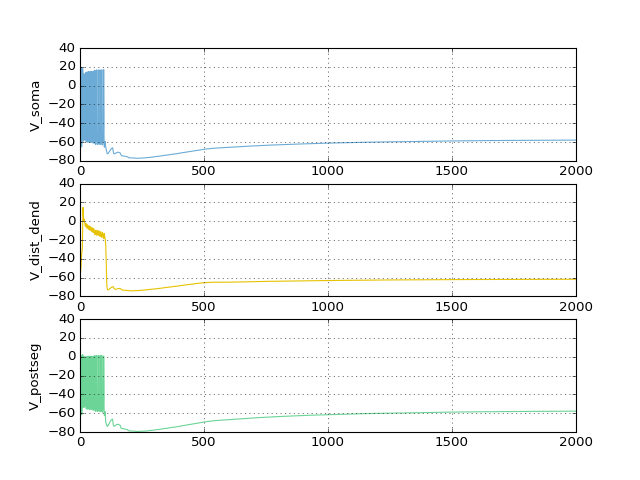

<IPython.core.display.Javascript object>


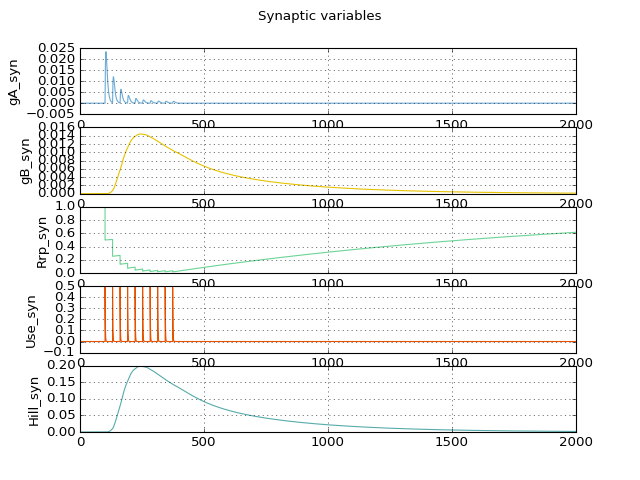

In [5]:
evaluator = StnModelEvaluator(StnModel.Gillies2005, PhysioState.NORMAL)

proto = StimProtocol.SINGLE_SYN_GABAA

# This sequence is equivalent to simulate_protocol()
evaluator.init_sim()
make_GABA_inputs(evaluator)
evaluator.rec_traces(proto)
evaluator.run_sim()

evaluator.plot_traces(proto)